# Generalization with OOP: The CBacktester Class

## Building the CBacktester Class from scratch: Instantiation

In [34]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import seaborn as sns
plt.style.use('seaborn')

In [49]:
class CBacktester():
    '''This is a docstring'''
    def __init__(self, filepath, symbol, start, end, tc):
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days/365.25))
        
    def __repr__(self):
        return "CBacktester: symbol = {}, start = {}, end = {}, ptc = {}".\
        format(self.symbol, self.start, self.end, self.tc)
        
    def get_data(self):
        raw = pd.read_csv(self.filepath, parse_dates=['time'], index_col='time')
        raw = raw[self.symbol].to_frame().fillna(method = 'ffill')
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol:'price'}, inplace=True)
        raw['returns'] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
    
    def upsample(self): #review this method
        data = self.data.copy()
        resamp = self.results.copy()
        
        data['position'] = resamp.position.shift() #review: not sure why this is being called
        data = data.loc[data.index[0]:].copy()
        data.position = data.position.shift(-1).ffill() #review: not sure why this is being called
        data.dropna(inplace=True)
        self.results = data
    
    def prepare_data(self, freq, window):
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        #resample() requires an agg method, such as last(), first(), mean(), etc
        resamp = data.resample(freq).last().dropna().iloc[:-1] #the last bar is incomplete, so drop it
        resamp['returns'] = np.log(resamp/resamp.shift(1)) #take returns on the resampled data
        resamp['roll_return'] = resamp['returns'].rolling(window).mean()
        resamp['position'] = -np.sign(resamp['roll_return'])
        resamp.dropna(inplace=True)
        self.results = resamp
        return resamp

    def run_backtest(self):
        data = self.results.copy()
        data['strategy'] = data['position'].shift(1) * data['returns']
        
        data['trades'] = data.position.diff().fillna(0).abs() #finds the difference between the rows in 'position'
        data.strategy = data.strategy - data['trades'] * self.tc #subtract trading costs from strategy
        self.results = data       
    
    def test_strategy(self, freq = 60, window = 1):
        self.freq = "{}".format(freq)
        self.window = window
        self.prepare_data(freq,window)
        self.upsample()
        self.run_backtest()
        
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
          
    def plot_results(self):
        if self.results is None:
            print('run test_strategy() first')
            return
        else:
            self.results[['creturns', 'cstrategy']].plot(figsize=(15,8))
            
    def optimize_strategy(self, freq_range, window_range):#, metric = "Multiple"):
        
        performance = []
        i = 0
        freqs = range(*freq_range)
        windows = range(*window_range)
        combinations = list(product(freqs, windows))
        
        for comb in combinations:
            clear_output(wait=True)
            display('Iteration {} of {}. Testing: freq = {}, window = {}'.\
                    format(i, len(combinations), comb[0], comb[1]))
            self.test_strategy(comb[0], comb[1])
            self.upsample() #review: not sure why this is being called
            self.run_backtest()
            performance.append(self.calculate_multiple(self.results.strategy))
            i += 1
            
        self.results_overview = pd.DataFrame(data = np.array(combinations), columns = ['Freq', 'Window'])
        self.results_overview['Performance'] = performance
        self.find_best_strategy()
            
    
    def find_best_strategy(self):
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0]
        window = best.Window.iloc[0]
        perf = best.Performance.iloc[0]
        clear_output(wait=True) #clear output again after last iteration
        print('Best Combination: Frequency: {} | Window: {} | {}: {}'.format(freq, window, 'Multiple', round(perf,6)))
        self.test_strategy(freq, window)
        
    def visualize_many(self):
        pass
    
    def add_sessions(self, visualize = False):
        data = self.results.copy()
        data['session'] = np.sign(data.trades).cumsum().shift(1).fillna(0)
        data['logr_session'] = data.groupby('session').strategy.cumsum() #cumulative log returns per trading session
        data['session_compound'] = data.groupby('session').strategy.cumsum().apply(np.exp) - 1 #cum simp returns p. tr. sess.
        
        
    def add_stop_loss(self, sl_thresh, report = True):
        pass
    
    def add_take_profit(self, tp_thresh, report = True):
        pass
    
    def define_sl_pos(self, group):
        pass
    
    def define_tp_pos(self, group):
        pass
    
    def add_leverage(self, leverage, sl = -0.5, report = True):
        pass
    
    def print_performance(self, leverage = False):
        pass
    
    def calculate_multiple(self, series):
        #return series.iloc[-1]/series.iloc[0] #this returns multiple if the series is PRICE data
        return np.exp(series.sum()) #returns muliple if the series is log returns (does work with nan in 0 pos)
        #return series.cumsum().apply(np.exp).iloc[-1]
    
    def calculate_cagr(self, series):
        pass
    
    def calculate_annulized_mean(self, series):
        pass
    
    def calculate_annualized_std(self, series):
        pass
    
    def calculate_sharpe(self, series):
        pass
    
    def calculate_sortino(self, series):
        pass
    
    def calculate_max_drawdown(self, series):
        pass
    
    def calculate_calmar(self, series):
        pass
    
    def calculate_max_dd_duration(self, series):
        pass
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()

In [50]:
spread = 1.4
pips = 0.0001

tester = CBacktester("one_minute.csv", "EURUSD", "2018-01-01", "2019-12-31", spread*pips/2) #mult by 2 for a 'round trip', multiply by pips
tester

CBacktester: symbol = EURUSD, start = 2018-01-01, end = 2019-12-31, ptc = 7e-05

Best Combination: Frequency: 201 | Window: 101 | Multiple: 1.412225


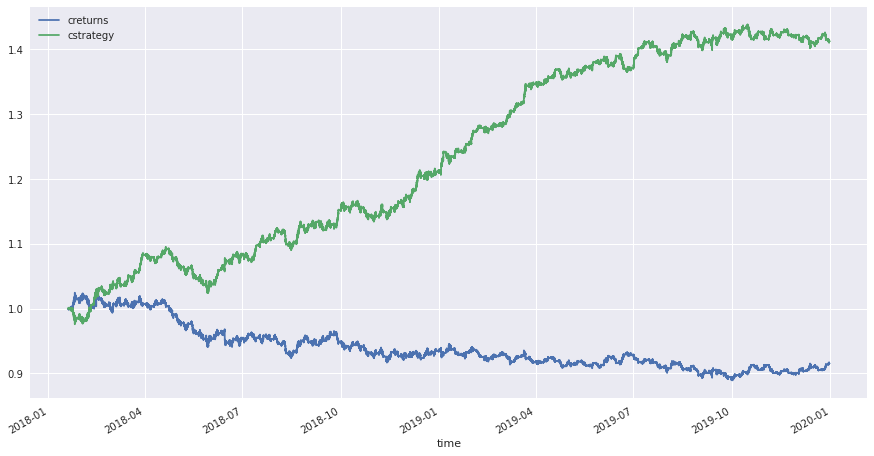

In [51]:
tester.prepare_data(60,1)
tester.run_backtest()
tester.test_strategy()
tester.optimize_strategy((201,400,20), (101,400,20))
tester.plot_results()

In [52]:
tester.results_overview.sort_values(by='Performance', ascending=False)

,Freq,Window,Performance
0,201,101,1.412225
36,241,221,1.164369
2,201,141,1.161220
120,361,101,1.157755
22,221,241,1.152725
...,...,...,...
43,241,361,0.975346
147,381,341,0.972861
72,281,341,0.955965
86,301,321,0.931445


In [58]:
tester.results.loc[tester.results.trades == 2]

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2018-02-07 23:11:00,1.22564,-0.000033,1.0,-0.000107,2.0,1.001765,0.997935
2018-02-08 02:32:00,1.22789,0.000138,-1.0,-0.000002,2.0,1.003604,0.999627
2018-02-08 05:53:00,1.22743,-0.000081,1.0,-0.000059,2.0,1.003228,0.999861
2018-02-08 15:56:00,1.22496,-0.000098,-1.0,-0.000238,2.0,1.001210,0.997710
2018-02-08 22:38:00,1.22456,0.000016,1.0,-0.000156,2.0,1.000883,0.997896
...,...,...,...,...,...,...,...
2019-12-23 15:29:00,1.10902,0.000090,-1.0,-0.000050,2.0,0.906447,1.419252
2019-12-24 11:35:00,1.10722,-0.000081,1.0,-0.000059,2.0,0.904976,1.421360
2019-12-24 18:17:00,1.10866,0.000108,-1.0,-0.000032,2.0,0.906153,1.423009
